# Klasifikasi Retakan Permukaan Beton Guna Dalam Pemeliharaan Infrastruktur

## Import Library

In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Load Gambar

In [2]:
data = []
labels = []
file_name = []

# Tentukan 3 label folder yang ingin dimuat
allowed_labels = ['label1', 'label2', 'label3']

# Loop hanya pada folder yang termasuk dalam allowed_labels
for sub_folder in os.listdir("dataset\\"):
    if sub_folder not in allowed_labels:
        continue  # Lewati folder yang tidak termasuk

    sub_folder_path = os.path.join("dataset\\", sub_folder)
    sub_folder_files = os.listdir(sub_folder_path)

    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join(sub_folder_path, filename)
        img = cv.imread(img_path)

        if img is None:
            continue  # Lewati file yang gagal dibaca

        img = img.astype(np.uint8)
        data.append(img)
        labels.append(sub_folder)
        file_name.append(filename)
        
print(f"Total gambar berhasil dimuat: {len(data)}")
print(f"Total label yang dimuat: {len(labels)}")


data = np.array(data)
labels = np.array(labels)

Total gambar berhasil dimuat: 600
Total label yang dimuat: 600


## Data Understanding

### Distribusi Data per Label

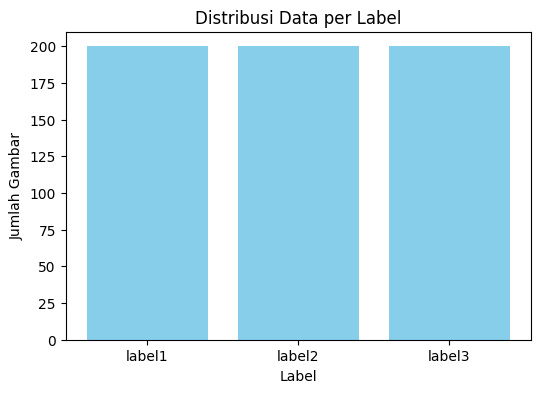

Label: label1, Jumlah: 200
Label: label2, Jumlah: 200
Label: label3, Jumlah: 200


In [3]:
# 1. Distribusi Data per Label
unique, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(6,4))
plt.bar(unique, counts, color='skyblue')
plt.title("Distribusi Data per Label")
plt.xlabel("Label")
plt.ylabel("Jumlah Gambar")
plt.show()

for u, c in zip(unique, counts):
    print(f"Label: {u}, Jumlah: {c}")

### Menampilkan Sampel Data dari Setiap Label

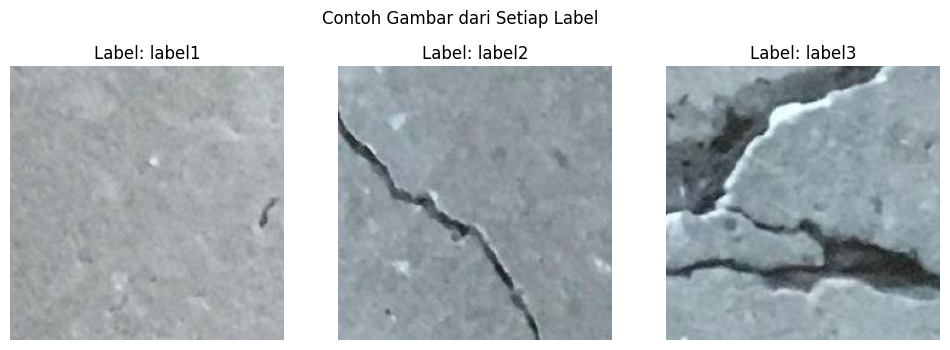

In [4]:
# 2. Menampilkan Sampel Data dari Setiap Label
plt.figure(figsize=(12,4))
for idx, label in enumerate(unique):
    idx_sample = np.where(labels == label)[0][0]
    plt.subplot(1, len(unique), idx+1)
    plt.imshow(data[idx_sample], cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.suptitle("Contoh Gambar dari Setiap Label")
plt.show()

### Statistik Dasar dari Gambar

In [5]:
# 3. Statistik Dasar Gambar
print("Ukuran gambar:", data[0].shape)
print("Nilai pixel min:", np.min(data), "max:", np.max(data), "mean:", np.mean(data))

Ukuran gambar: (227, 227, 3)
Nilai pixel min: 0 max: 255 mean: 166.0229590780596


### Distribusi Brightness Gambar

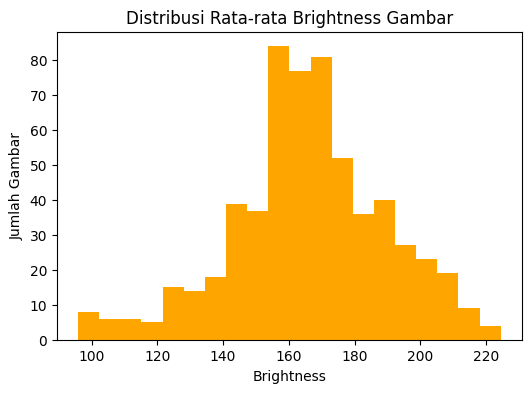

In [6]:
# 4. Distribusi Brightness
brightness = [np.mean(img) for img in data]
plt.figure(figsize=(6,4))
plt.hist(brightness, bins=20, color='orange')
plt.title("Distribusi Rata-rata Brightness Gambar")
plt.xlabel("Brightness")
plt.ylabel("Jumlah Gambar")
plt.show()

## Data Preparation

### Menentukan Function Preprocessing

In [30]:
def grayscaling_manual(img):
    b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
    gray = 0.114 * b + 0.587 * g + 0.299 * r
    return gray.astype(np.uint8)

def ekualisasi_hist_manual(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')
    img_eq = cdf_final[img_gray]
    return img_eq

def median_filter_manual(img, size=3):
    return cv.medianBlur(img, size)

def thresholding_manual(img_gray, thresh=128):
    binary = np.where(img_gray >= thresh, 255, 0).astype(np.uint8)
    return binary

def sobel_manual(img_gray):
    # Kernel Sobel
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]])
    # Padding citra
    img_padded = np.pad(img_gray, 1, mode='edge')
    Gx = np.zeros_like(img_gray, dtype=np.float32)
    Gy = np.zeros_like(img_gray, dtype=np.float32)
    for i in range(img_gray.shape[0]):
        for j in range(img_gray.shape[1]):
            region = img_padded[i:i+3, j:j+3]
            Gx[i, j] = np.sum(Kx * region)
            Gy[i, j] = np.sum(Ky * region)
    magnitude = np.hypot(Gx, Gy)
    magnitude = (magnitude / magnitude.max() * 255).astype(np.uint8)
    return Gx, Gy, magnitude

def dilation_manual(img, kernel_size=3):
    pad = kernel_size // 2
    img_padded = np.pad(img, pad, mode='constant', constant_values=0)
    dilated = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = img_padded[i:i+kernel_size, j:j+kernel_size]
            dilated[i, j] = np.max(region)
    return dilated

def erosion_manual(img, kernel_size=3):
    pad = kernel_size // 2
    img_padded = np.pad(img, pad, mode='constant', constant_values=0)
    eroded = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = img_padded[i:i+kernel_size, j:j+kernel_size]
            eroded[i, j] = np.min(region)
    return eroded

def closing_manual(img, kernel_size=3):
    dilated = dilation_manual(img, kernel_size)
    closed = erosion_manual(dilated, kernel_size)
    return closed

In [31]:
dataPreprocessed = []
for i in range(len(data)):
    img = data[i]
    gray = grayscaling_manual(img)
    eq = ekualisasi_hist_manual(gray)
    median = median_filter_manual(eq, size=3)
    binary = thresholding_manual(median, thresh=128)  # Tambahkan thresholding di sini
    # Contoh: gunakan magnitude dari sobel sebagai hasil akhir
    _, _, sobel_mag = sobel_manual(binary)
    closed = closing_manual(sobel_mag, kernel_size=3)
    dataPreprocessed.append(closed)

dataPreprocessed = np.array(dataPreprocessed)

## Feature Extraction

In [13]:
def glcm(img, derajat):
    if derajat == 0:
        angle = [0]
    elif derajat == 45:
        angle = [np.pi/4]
    elif derajat == 90:
        angle = [np.pi/2]
    elif derajat == 135:
        angle = [3*np.pi/4]
    else:
        raise ValueError("Derajat harus 0, 45, 90, atau 135")
    
    glcm_matrix = graycomatrix(img, [1], angle, 256, symmetric=True, normed=True)
    return glcm_matrix

In [14]:
def correlation(matrix):
    return graycoprops(matrix, 'correlation')[0, 0]
def dissimilarity(matrix):
    return graycoprops(matrix, 'dissimilarity')[0, 0]
def homogeneity(matrix):
    return graycoprops(matrix, 'homogeneity')[0, 0]
def contrast(matrix):
    return graycoprops(matrix, 'contrast')[0, 0]
def ASM(matrix):
    return graycoprops(matrix, 'ASM')[0, 0]
def energy(matrix):
    return graycoprops(matrix, 'energy')[0, 0]
def entropyGLCM(matrix):
    return entropy(matrix.ravel())

In [15]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [16]:
Kon0, Kon45, Kon90, Kon135 = [], [], [], []
homo0, homo45, homo90, homo135 = [], [], [], []
diss0, diss45, diss90, diss135 = [], [], [], []
entr0, entr45, entr90, entr135 = [], [], [], []
ASM0, ASM45, ASM90, ASM135 = [], [], [], []
energy0, energy45, energy90, energy135 = [], [], [], []
corr0, corr45, corr90, corr135 = [], [], [], []

In [17]:
for i in range(len(dataPreprocessed)):
    # Sudut 0
    D0 = Derajat0[i]
    Kon0.append(contrast(D0))
    diss0.append(dissimilarity(D0))
    homo0.append(homogeneity(D0))
    entr0.append(entropyGLCM(D0))
    ASM0.append(ASM(D0))
    energy0.append(energy(D0))
    corr0.append(correlation(D0))

In [18]:
for i in range(len(dataPreprocessed)):
    # Sudut 45
    D45 = Derajat45[i]
    Kon45.append(contrast(D45))
    diss45.append(dissimilarity(D45))
    homo45.append(homogeneity(D45))
    entr45.append(entropyGLCM(D45))
    ASM45.append(ASM(D45))
    energy45.append(energy(D45))      # Perbaiki di sini
    corr45.append(correlation(D45))

In [19]:
for i in range(len(dataPreprocessed)):
    # Sudut 90
    D90 = Derajat90[i]
    Kon90.append(contrast(D90))
    diss90.append(dissimilarity(D90))
    homo90.append(homogeneity(D90))
    entr90.append(entropyGLCM(D90))
    ASM90.append(ASM(D90))
    energy90.append(energy(D90))
    corr90.append(correlation(D90))

In [20]:
for i in range(len(dataPreprocessed)):
    # Sudut 135
    D135 = Derajat135[i]
    Kon135.append(contrast(D135))
    diss135.append(dissimilarity(D135))
    homo135.append(homogeneity(D135))
    entr135.append(entropyGLCM(D135))
    ASM135.append(ASM(D135))
    energy135.append(energy(D135))
    corr135.append(correlation(D135))

## Hasil Ekstraksi ke CSV

In [21]:
dataTable = {
    'Filename': file_name, 'Label': labels,
    'Contrast0': Kon0, 'Contrast45': Kon45, 'Contrast90': Kon90, 'Contrast135': Kon135,
    'Homogeneity0': homo0, 'Homogeneity45': homo45, 'Homogeneity90': homo90, 'Homogeneity135': homo135,
    'Dissimilarity0': diss0, 'Dissimilarity45': diss45, 'Dissimilarity90': diss90, 'Dissimilarity135': diss135,
    'Entropy0': entr0, 'Entropy45': entr45, 'Entropy90': entr90, 'Entropy135': entr135,
    'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
    'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
    'Correlation0': corr0, 'Correlation45': corr45, 'Correlation90': corr90, 'Correlation135': corr135,
}
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_2.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_2.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,ts (1).jpg,label1,233.466220,367.067272,218.130755,411.201895,0.418491,0.229356,0.410810,0.229469,...,0.002302,0.000754,0.048784,0.027400,0.047979,0.027465,0.824867,0.722821,0.836371,0.689494
1,ts (10).jpg,label1,265.961132,431.384290,189.982613,395.116101,0.392696,0.220123,0.384233,0.214087,...,0.002178,0.000762,0.048004,0.028255,0.046673,0.027598,0.846116,0.749581,0.890077,0.770635
2,ts (100).jpg,label1,420.310514,775.032226,457.928697,720.376576,0.412102,0.212065,0.418440,0.211902,...,0.001629,0.000447,0.039658,0.021130,0.040365,0.021139,0.836673,0.695395,0.822055,0.716876
3,ts (101).jpg,label1,314.419711,499.424975,272.854743,515.795716,0.413306,0.216383,0.408870,0.214600,...,0.002082,0.000611,0.045754,0.024844,0.045624,0.024715,0.817383,0.707436,0.841525,0.697846
4,ts (102).jpg,label1,346.683716,713.879670,382.780944,551.423839,0.399946,0.225117,0.413531,0.224311,...,0.002212,0.000707,0.045602,0.026585,0.047036,0.026582,0.841833,0.673196,0.825365,0.747566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,rst (95).jpg,label3,189.685314,375.302765,242.814783,378.501331,0.455429,0.282273,0.441049,0.279366,...,0.003450,0.001740,0.060040,0.042460,0.058735,0.041711,0.878861,0.759918,0.844931,0.757872
596,rst (96).jpg,label3,174.357296,312.376654,257.447429,430.315608,0.490566,0.319559,0.472465,0.306468,...,0.004827,0.002606,0.071374,0.052934,0.069473,0.051049,0.889754,0.802343,0.837216,0.727717
597,rst (97).jpg,label3,118.172625,373.271360,218.853222,217.176874,0.485819,0.312545,0.477918,0.319712,...,0.005370,0.002913,0.074659,0.052808,0.073279,0.053968,0.897306,0.675557,0.809812,0.811232
598,rst (98).jpg,label3,127.934622,301.313611,180.864723,252.719908,0.460204,0.290477,0.450233,0.294191,...,0.003916,0.001804,0.062938,0.042099,0.062576,0.042475,0.896740,0.756627,0.854019,0.795876


## Feature Selection

### Menggunakan ANOVA

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif

# Pisahkan fitur dan label
X = hasilEkstrak.drop(columns=['Filename', 'Label'])
y = hasilEkstrak['Label']

# Pilih 10 fitur terbaik dengan ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Tampilkan nama fitur terpilih
selected_features = X.columns[selector.get_support()]
print("Fitur terbaik hasil seleksi ANOVA:", list(selected_features))

# Jika ingin DataFrame hasil seleksi:
df_selected = hasilEkstrak[selected_features]
df_selected['Label'] = y
df_selected.head()

Fitur terbaik hasil seleksi ANOVA: ['Homogeneity0', 'Homogeneity45', 'Homogeneity135', 'ASM0', 'ASM45', 'ASM135', 'Energy0', 'Energy45', 'Energy90', 'Energy135']


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21096\3596497498.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Label'] = y


,Homogeneity0,Homogeneity45,Homogeneity135,ASM0,ASM45,ASM135,Energy0,Energy45,Energy90,Energy135,Label
0,0.418491,0.229356,0.229469,0.002380,0.000751,0.000754,0.048784,0.027400,0.047979,0.027465,label1
1,0.392696,0.220123,0.214087,0.002304,0.000798,0.000762,0.048004,0.028255,0.046673,0.027598,label1
2,0.412102,0.212065,0.211902,0.001573,0.000446,0.000447,0.039658,0.021130,0.040365,0.021139,label1
3,0.413306,0.216383,0.214600,0.002093,0.000617,0.000611,0.045754,0.024844,0.045624,0.024715,label1
4,0.399946,0.225117,0.224311,0.002080,0.000707,0.000707,0.045602,0.026585,0.047036,0.026582,label1


## Splitting Data

In [23]:
X = df_selected.drop(columns=['Label'])
y = df_selected['Label']

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Jumlah data train:", len(X_train))
print("Jumlah data test:", len(X_test))

Jumlah data train: 480
Jumlah data test: 120


## Feature Normalization

### Menggunakan Standardization

In [24]:
scaler = StandardScaler()
# Fit scaler pada data training, lalu transform data training dan testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (480, 10)
X_test_scaled shape: (120, 10)


## Modeling

### Define Model

In [25]:
def generateClassificationReport(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [26]:
# Train Random Forest Classifier
rf.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model with the training set
print("------Random Forest: Training Set------")
y_pred = rf.predict(X_train_scaled)
generateClassificationReport(y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Random Forest: Testing Set------")
y_pred = rf.predict(X_test_scaled)
generateClassificationReport(y_test, y_pred)

------Random Forest: Training Set------
              precision    recall  f1-score   support

      label1       0.97      0.96      0.96       160
      label2       0.94      0.95      0.95       160
      label3       0.98      0.98      0.98       160

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480

[[153   6   1]
 [  5 152   3]
 [  0   3 157]]
Accuracy: 0.9625

------Random Forest: Testing Set------
              precision    recall  f1-score   support

      label1       0.72      0.70      0.71        40
      label2       0.62      0.65      0.63        40
      label3       0.87      0.85      0.86        40

    accuracy                           0.73       120
   macro avg       0.74      0.73      0.73       120
weighted avg       0.74      0.73      0.73       120

[[28 12  0]
 [ 9 26  5]
 [ 2  4 34]]
Accuracy: 0.7333333333333333


### Train SVM Classifier

In [27]:
# Train SVM Classifier
svm.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model with the training set
print("\n------SVM: Training Set------")
y_pred = svm.predict(X_train_scaled)
generateClassificationReport(y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------SVM: Testing Set------")
y_pred = svm.predict(X_test_scaled)
generateClassificationReport(y_test, y_pred)


------SVM: Training Set------
              precision    recall  f1-score   support

      label1       0.72      0.69      0.70       160
      label2       0.62      0.60      0.61       160
      label3       0.84      0.91      0.87       160

    accuracy                           0.73       480
   macro avg       0.73      0.73      0.73       480
weighted avg       0.73      0.73      0.73       480

[[110  43   7]
 [ 43  96  21]
 [  0  15 145]]
Accuracy: 0.73125

------SVM: Testing Set------
              precision    recall  f1-score   support

      label1       0.75      0.82      0.79        40
      label2       0.66      0.62      0.64        40
      label3       0.89      0.85      0.87        40

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120

[[33  7  0]
 [11 25  4]
 [ 0  6 34]]
Accuracy: 0.7666666666666667


### Train KNN Classifier

In [28]:
# Train KNN Classifier
knn.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model with the training set
print("\n------KNN: Training Set------")
y_pred = knn.predict(X_train_scaled)
generateClassificationReport(y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------KNN: Testing Set------")
y_pred = knn.predict(X_test_scaled)
generateClassificationReport(y_test, y_pred)


------KNN: Training Set------
              precision    recall  f1-score   support

      label1       0.80      0.79      0.80       160
      label2       0.74      0.72      0.73       160
      label3       0.89      0.91      0.90       160

    accuracy                           0.81       480
   macro avg       0.81      0.81      0.81       480
weighted avg       0.81      0.81      0.81       480

[[127  30   3]
 [ 29 116  15]
 [  3  11 146]]
Accuracy: 0.8104166666666667

------KNN: Testing Set------
              precision    recall  f1-score   support

      label1       0.72      0.82      0.77        40
      label2       0.68      0.62      0.65        40
      label3       0.92      0.85      0.88        40

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120

[[33  7  0]
 [12 25  3]
 [ 1  5 34]]
Accuracy: 0.7666666666666667


## Evaluation With Confusion Matrix

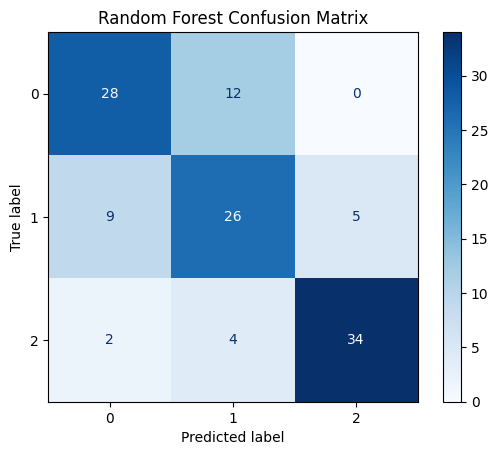

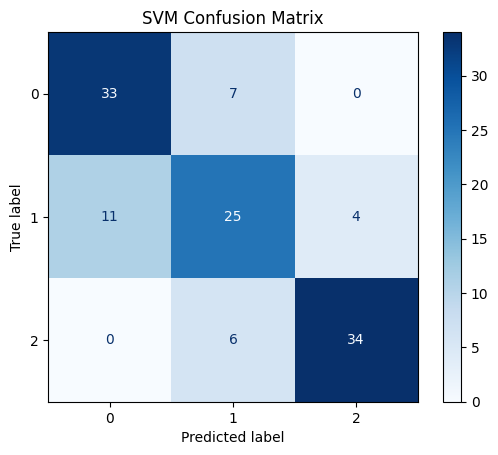

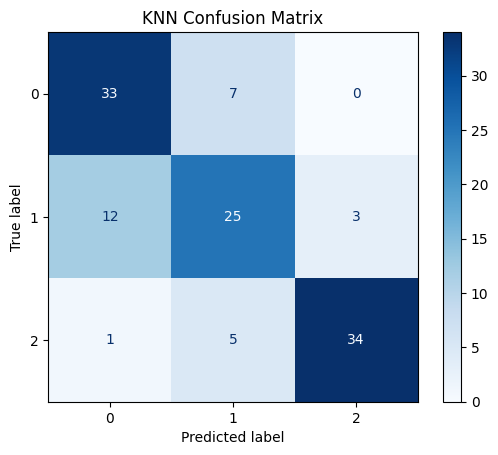

In [29]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test_scaled), "Random Forest Confusion Matrix")

# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test_scaled), "SVM Confusion Matrix")

# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test_scaled), "KNN Confusion Matrix")